>**Alumnos**: *Arturo Barbero Pérez y Adrián Ogáyar Sanchez*

>**Grupo**: *11*

***

# REGRESIÓN LOGÍSTICA MULTI-CLASE

## VISUALIZACIÓN DE LOS DATOS

Importamos las librerías que van a ser necesarias durante el desarrollo de la práctica: La librería **Pyplot** es necesaría para poder hacer el graficado de los números contenidos en la matriz de datos. **NumPy** es la librería que nos permite realizar calculos entre matrices y vectores de manera de más eficiente gracias a la vectorización. Importamos además **loadmat** que se va a encargar de obtener los datos del fichero mat. Por último, utilizamos **Optimize** de SciPy, que nos permite obtener el vector θ optimizado para cada clase.

In [1]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt

In [2]:
data = loadmat('ex3data1.mat')

# se pueden consultar las claves con data.keys()
y = data['y']
X = data['X']
# almacena los datos leídos en X, y

El fichero *ex3data1.mat* contiene 5000 ejemplos de entrenamiento en formato nativo para matrices de Octave/Matlab. El fichero se carga con la función loatmat que devuelve un diccionario del que podemos extraer las matrices *X* e *y*. 
Cada ejemplo de entrenamiento es una imagen de 20x20 pixeles donde cada píxel está representado por un número real que indica la intensidad en escala de grises de ese punto. Cada matriz de 20x20 se ha desplegado en un vector de 400 elementos que ocupa una fila de la matriz X. De esta forma X es una matriz de orden 5000x400.

(-0.5, 199.5, 19.5, -0.5)

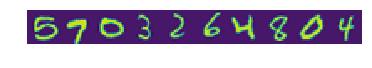

In [3]:
# Selecciona aleatoriamente 10 ejemplos de entrenamiento y los pinta

sample = np.random.choice(X.shape[0], 10)
plt.imshow( X[ sample, :].reshape(-1, 20).T)
plt.axis ('off')

## VECTORIZACIÓN DE LA REGRESIÓN LOGÍSTICA

### Vectorización de la función de coste

El valor de la función de coste (sin regularizar) en regresión logística viene dado por la siguiente expresión:

$$J(\theta) = \frac{1}{m} \sum_{i=1}^{m}[ -y^{(i)} log(h_\theta(x^{(i)})) - (1 - y^{(i)}) log(1 - h_\theta(x^{(i)})) ]$$

Donde *m* es el número de ejemplos de entrenamiento y $h_\theta$ es la función sigmoide que viene dada por la expresión:

$$g(z) = \frac{1}{1 + e^{-z}}$$

La función de coste podemos darla vectorizada con los siguientes cálculos:


$$J(\theta) = - \frac{1}{m}{((log( g(X\theta) ))^{T}y) + (log(1 - g(X\theta)))^{T}(1-y))}$$


De esta manera, el sumatorio es más fácil de calcular ya que las multiplicaciones se realizan entre matrices, siendo así de una manera más rápida. Mediante este método nos ahorramos la necesidad de bucles, ayudados de la multiplicación elemento a elemento y la función sumatorio.

Pasemos a declarar las funciones necesarias:

In [4]:
g = lambda z: 1 / (1 + np.exp(-z))

In [5]:
def funCoste(theta, x, y):
    return -1/len(x) * (((np.log( g(x.dot(theta)) )).T).dot(y) + 
                        ((np.log( 1 - g(x.dot(theta)) )).T).dot(1-y))

### Vectorización del gradiente

El gradiente de la función de coste (sin regularizar) es un vector de la misma longitud de $\theta$ donde la componente *j* viene dada por la expresión:

$$\frac{\partial J(\theta)}{\partial \theta} = \frac{1}{m} \sum_{i=1}^{m}( h_\theta(x^{(i)}) - y^{(i)})x^{(i)}_j$$

Pudiendo darla vectorizada de la siguiente manera:

$$\frac{\partial J(\theta)}{\partial \theta} = \frac{1}{m}{ X^{T} (g(X\theta) - y)}$$

In [6]:
def gradient(theta, x, y):
    return 1/len(x) * (x.T).dot(g(x.dot(theta)) - y)

### Vectorización de la versión regularizada

Añadimos ahora el término de regularización de la función de coste vectorizada y el gradiente de la regresión logística


$$J(\theta) = [ \frac{1}{m} \sum_{i=1}^{m}[ -y^{(i)} log(h_\theta(x^{(i)})) - (1 - y^{(i)}) log(1 - h_\theta(x^{(i)})) ] + \frac{\lambda}{2m} \sum_{j=1}^{n} \theta^{2}_j ] $$

$$
\frac{\partial J(\theta)}{\partial\theta_j} = \begin{cases}
\frac{1}{m} \sum_{i=1}^{m}( h_\theta(x^{(i)}) - y^{(i)})x^{(i)}_j
& \mbox{si $j=0$,}\\
(\frac{1}{m} \sum_{i=1}^{m}( h_\theta(x^{(i)}) - y^{(i)})x^{(i)}_j) + \frac{\lambda}{m}  \theta_j & \mbox{si $j >= 1$}
\end{cases}
$$

Dadas vectorizadas respectivamente de la siguiente manera:

$$J(\theta)= \frac{-1}{m} ((log(g(X\theta)))^Ty+log(1-g(X\theta)))^T(1-y)+\frac{\lambda}{2m}\sum_{j=1}^{n} \theta^{2}_j$$

$$\frac{\partial J(\theta)}{\partial\theta_j}=\frac{1}{m}X^T(g(X\theta)-y)+\frac{\lambda}{m}\theta_j$$

In [7]:
def funCosteReg(theta, x, y, lamb):
    return -1/len(x) * (((np.log( g(x.dot(theta)) )).T).dot(y) +
                        ((np.log( 1 - g(x.dot(theta)) )).T).dot(1-y) +
                        (lamb/(2*len(x))*(np.sum(theta))**2))

def gradientReg(theta, x, y, lamb):
    return 1/len(x) * (x.T).dot(g(x.dot(theta)) - y) + (lamb/len(x))*theta

## CLASIFICACIÓN DE UNO FRENTE A TODOS

Vamos a entrenar un clasificador por regresión logística para cada una de las 10 clases del conjunto de datos. Lo implementaremos con una función que devuelve una matriz $\theta$ de orden Kx(N+1) donde cada fila de la matriz corresponde a los parámetros aprendidos para el clasificador de una de las clases. Esto lo realizaremos mediante una función (clasificadorClase) que devuelve el vector $\theta$ aprendido para una determinada clase.


In [8]:
def clasificadorClase(X, y, num_etiquetas, reg):
    
    thetaAux = np.zeros((len(X[0])))
    result = opt.fmin_tnc(func=funCosteReg, x0=thetaAux, fprime=gradientReg,
                          args=(X, y.ravel(), reg))
    
    return result[0]

La función oneVsAll es la encargada de devolver la matriz $\theta$. En ella se crea una matriz de ceros de orden Kx(N+1) y mediante un bucle que selecciona que ejemplos de entrenamiento pertenecen a una clase determinada, indicada por el indice *i*.
Con esto lo que hacemos es poner a 1, en el vector *yaux*, la clase que queremos clasificar y el resto a 0. Una vez hecho esto, realizamos la regresión llamando a la funcion *clasificadorClase* que optimiza los parametros $\theta$, necesarios para poder separar los ejemplos de entrenamiento de la clase que estamos clasificando, del resto de clases.
Esto lo realizamos con todas las clases para obtener finalmente la matriz que debemos devolver.


In [9]:
def oneVsAll(X, y, num_etiquetas, reg):
    # Matriz theta de orden Kx(N+1) inicializada con 0's, donde K es el
    # número de clases y N+1 el número de etiquetas
    theta = np.zeros((num_etiquetas, len(X[0])))

    for i in range(1, num_etiquetas + 1):
        yaux = np.where(y == i, 1, 0)
        thetaAux = np.zeros((len(X[0])))
        theta[i-1, :] = clasificadorClase(X, yaux, num_etiquetas, reg)
    
    return theta

In [10]:
theta_opt = oneVsAll(X, y, 10, 0.1)
print("Matriz theta: " + str(theta_opt))

Matriz theta: [[ 0.00000000e+00  0.00000000e+00  1.13365698e-04 ...  7.49964770e-03
  -6.86389008e-09  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -2.46378207e-04 ...  1.57012381e-02
  -1.68189112e-03  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -1.49118731e-04 ... -1.46300053e-05
  -3.54386814e-07  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00 -2.38067998e-04 ... -1.67848254e-02
   1.78009062e-03  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -1.24782815e-06 ... -4.06004280e-02
   3.96151675e-03  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -1.59755341e-07 ... -2.60753472e-04
   2.25408480e-05  0.00000000e+00]]


Una vez hemos entrenado el clasificador y hemos obtenido las $\theta$ optimizadas. Vamos a comprobar cuantos ejemplos de entrenamiento clasifica correctamente. Para ello, para cada ejemplo de entrenamiento calculamos la probabilidad de que pertenezca a una clase u otra y obtenemos los índices de los máximos de cada fila. Este índice coincide con la clase que ha obtenido la mayor probabilidad.
Comparamos estos indices con el vector *y* que contiene las etiquetas que se han asignado a cada imagen, y obtenemos un vector con *True* o *False* dependiendo de si los elementos coindicen entre sí o no.
Por último contamos la cantidad de *True* que hay en el vector.

In [11]:
#Calculamos la probabilidad de que pertenezca a una clase u otra
probabilidad = g(X.dot(theta_opt.T))

#Obtenemos el índice del elemento con mayor probabilidad
indices = np.argmax(probabilidad, axis=1)
indices+=1

#Vector de booleanos
porcentaje = (indices == y.ravel())
clasificados = porcentaje[porcentaje == True]

print("Porcentaje de clasificados correctamente: " 
      + str((len(clasificados)/len(X))*100) + "%")

Porcentaje de clasificados correctamente: 95.92%


# Redes neuronales

En este caso usaremos unos pesos proporcionados para crear una red neuronal y evaluar su precisión.

Para esto leemos el fichero *ex3weights.mat*, que contine las $\theta$s.

In [12]:
weights = loadmat('ex3weights.mat')
theta1, theta2 = weights['Theta1'], weights['Theta2']

Ahora crearemos una red neuronal para que calcule la probabilidad de que cada caso de prueba sea uno de los números.

La red neuronal está compuesta por 400 nodos en la capa externa y 25 en la oculta, terminando con 10 valores como resultado de la operación.

Para esto utilizaremos operaciones matriciales que agilicen el proceso (ya que se tratan de enormes cantidades de datos).

Para obtener los resultados de la primera capa multiplicamos las matrices $x$ y $\theta_1^T$ y las metemos en la función sigmoide (*g()*) que ya habíamos declarado. De este modo tenemos una matriz **z** con los nodos de la capa oculta.

Para la segunda capa multiplicamos la matriz **z** por $\theta_2^T$, metiéndolas también en *g()* y obteniendo así *h(x)*, una matriz de $5000x10$, siendo las filas los casos de prueba y las columnas las probabilidades de pertenecer a cada número.

In [13]:
def redNeuronal(x) :
    one = np.ones((len(x), 1))
    x = np.hstack([one, x])

    z = g(x.dot(theta1.T))
    
    one = np.ones((len(z), 1))
    z = np.hstack([one, z])
   
    return g(z.dot(theta2.T))

Finalmente vamos a calcular el porcentaje de acierto de la red neuronal.

In [14]:
#Calculamos la probabilidad de que pertenezca a una clase u otra
probabilidades = redNeuronal(X)

#Obtenemos el índice del elemento con mayor probabilidad
maximos = np.argmax(probabilidades, axis=1)
maximos += 1

#Vector de booleanos
porcentaje = (maximos == y.ravel())

clasificados = porcentaje[porcentaje == True]

print("Porcentaje de clasificados correctamente: " 
      + str(len(clasificados)/len(X)*100)+"%")

Porcentaje de clasificados correctamente: 97.52%


Como se puede apreciar, el porcentaje de acierto es del 97.52%, considerablemente superior al anterior.